In [ ]:
Лабораторная работа 2. Простейший анализ тональности текста.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import copy

In [2]:
# загружаем твиты из файла
data = [] # [[], ...] [[[20, 32], 'Все верно #WorldCupDraw #ЖеребьевкаЧМ https://t.co/vIJ908sKpM'], ...]


with open('tweets.txt','r', encoding = 'utf8') as file:
    element = []
    date = False
    
    for line in file:
        line = line.rstrip()
        if date:
            element.append([x for x in line.split(' ')[1].split(':')])
            date = False
        elif line == '**********':
            if len(element) > 1:
                data.append(element)
            element = []
            date = True
        else:
            if len(element) == 2:
                element[1] = element[1] + " " + line
            else:
                element.append(line)
                
    if len(element) > 1:
        data.append(element)

In [3]:
# 1. Подготовка и обработка данных.
import re
import string
reviews = copy.deepcopy(data) # [[[20, 32], 'верно жеребьевкачм'], ...]


stopword_list = nltk.corpus.stopwords.words('russian')
stopword_list = stopword_list + ['что', 'это', 'вот', 'быть', 'как', 'в', 'к', 'на']


# делим текст на слова, убираем пробелы
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens


# убираем незначащие символы
def remove_special_characters(text):
    tokens = tokenize_text(text)
    avoid = string.punctuation + '…–—»«'
    avoid = avoid.replace('(', '')
    avoid = avoid.replace(')', '')
    avoid += string.ascii_lowercase
    avoid += string.digits
    # создаем регулярный объект
    pattern = re.compile('[{}]'.format(avoid))
    # sub заменяет в строке слова из pattern на ' '
    filtered_text = ' '.join([pattern.sub(' ', token) for token in tokens])
    return filtered_text


# убираем стоп-слова и слова, которые меньше трех букв
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if (token not in stopword_list) \
                       & ((len(token) > 3) | (token in ['(', ')']))]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


words = {}  # {'верно': [1], ...}
number_of_words = 0  # количество слов всего
for i in range(len(reviews)):
    checked_words = []
    text = reviews[i][1].lower()    
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    text = text.replace('ё', 'е')
    reviews[i][1] = text
    
    for word in text.split(' '):
        number_of_words += 1
        if word not in checked_words:
            checked_words.append(word)
            if word in words:
                words[word][0] += 1
            else:
                words[word] = [1]

In [4]:
# 2. Частотный анализ.
from math import log10, floor
def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))


# sorted words by number [('жеребьевкачм', [127]), ...] 
words_count = sorted(words.items(), key=lambda k: k[1][0], reverse = True)

frequency = open('frequency.txt', 'w', encoding = 'utf8')
for word_tuple in words_count:
    frequency.write(word_tuple[0] + ' - ' + str(word_tuple[1][0]) +' - '+ \
                    str(round_to_1(word_tuple[1][0]/len(reviews) * 100)) + '%\n')

    
frequency.close()
for i in range(5):
    print(words_count[i][0] + ' - ' + str(words_count[i][1][0]) +' - '+ \
                    str(round_to_1(words_count[i][1][0]/len(reviews) * 100)) + '%')

жеребьевкачм - 127 - 80.0%
группы - 33 - 20.0%
россии - 30 - 20.0%
группа - 22 - 10.0%
россия - 22 - 10.0%


In [186]:
# сохраняем слова для оценки


estimations = open('estimations.txt', 'w', encoding = 'utf8')
for word_tuple in words_count:
    estimations.write(word_tuple[0] + ' 0\n')
estimations.close()

In [5]:
# 3. Эмпирическая оценка/маркировка отдельных слов.
words_with_estimation = copy.deepcopy(words)  # {'верно': [1, 1], ...} {word: [amount, label]}


with open('estimations.txt', 'r', encoding = 'utf8') as estimations:
        for line in estimations:
            line = line.split(' ')
            words_with_estimation[line[0]].append(int(line[1]))

In [6]:
# 4. Выбор правила оценки твита. Оценка твитов.
def print_and_write(file, label, bad, neu, pos):
    file.write(label + '\n')
    g = 'Good - ' + str(pos) + ' - ' + str(round(pos/len(estimated_reviews), 2)) + '%\n'
    b = 'Bad - ' + str(bad) + ' - ' + str(round(bad/len(estimated_reviews), 2)) + '%\n'
    n = 'Neutral - ' + str(neu) + ' - ' + str(round(neu/len(estimated_reviews), 2)) + '%\n'
    file.write(g)
    file.write(b)
    file.write(n)
    print(label)
    print(g)
    print(b)
    print(n)

    
def estimating_tweets(estimated_reviews, border):
    bad = 0
    neutral = 0
    positive = 0
    for review in estimated_reviews:
        label = 0
        number = 0
        for word in review[1].split(' '):
            label += words_with_estimation[word][1]
            number += 1
        label /= number
        if label > border:
            label = 1
            positive += 1
        elif label < -border:
            label = -1
            bad += 1
        else:
            label = 0
            neutral += 1
        review.append(label)
    return bad, neutral, positive


estimated_reviews = copy.deepcopy(reviews)  # [[[20, 32], 'верно жеребьевкачм', 1], ...]

bad, neutral, positive = estimating_tweets(estimated_reviews, 0)
bad_25, neutral_25, positive_25 = estimating_tweets(estimated_reviews, 0.25)

classify = open('classifications.txt', 'w', encoding = 'utf8')    
print_and_write(classify, 'Sum of estimates', bad, neutral, positive)
print_and_write(classify, 'Over 25%', bad_25, neutral_25, positive_25)
classify.close()

Sum of estimates
Good - 51 - 0.32%

Bad - 42 - 0.26%

Neutral - 68 - 0.42%

Over 25%
Good - 13 - 0.08%

Bad - 14 - 0.09%

Neutral - 134 - 0.83%



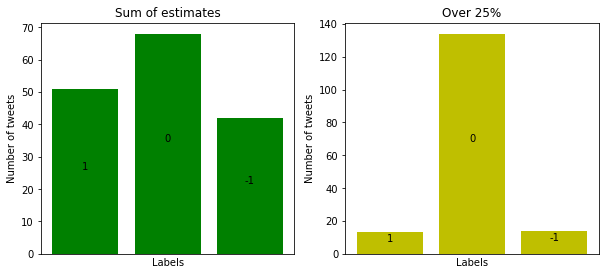

In [7]:
def autolabel(container, origin):
    labels = ['1','0','-1']

    for bar, label in zip(container, labels):
        height = bar.get_height()
        width = bar.get_width()
        origin.text(bar.get_x() + width/2, height/2, label, ha='center', va='bottom')

        
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4.25)

array = np.arange(3) 

bar_SOE = fig.add_subplot(121)
bar_SOE_container = bar_SOE.bar(array, (positive, neutral, bad), color='g')
bar_SOE.set_title('Sum of estimates')
bar_SOE.set_ylabel('Number of tweets')
bar_SOE.set_xlabel('Labels')
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')


bar_25 = fig.add_subplot(122)
bar_25_container = bar_25.bar(array, (positive_25, neutral_25, bad_25), color='y')
bar_25.set_title('Over 25%')
bar_25.set_ylabel('Number of tweets')
bar_25.set_xlabel('Labels')
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')


autolabel(bar_25_container, bar_25)
autolabel(bar_SOE_container, bar_SOE)
plt.savefig('estimates.png')
plt.show()

In [8]:
# 5. Части речи.
def print_and_write_adj(file, title, adjs, words, words_number):
    adjectives.write(title + '\n')
    print(title)
    for adj in adjs:
        output = adj[0]+' - '+str(adj[1][0])+' - '+str(round(adj[1][0]/len(words_with_estimation), 3))+'%\n'
        adjectives.write(output)
        print(output)
        words.append(adj[0])
        words_number.append(adj[1][0])


pos_adj = []
neg_adj = []


for word in sorted(words_with_estimation.items(), key=lambda k: k[1][0], reverse = True):
    tag = nltk.tag.pos_tag([word[0]], lang='rus')
    
    if (('A=' in tag[0][1])|(tag[0][1] == 'A'))&(word[1][1] == 1)&(len(pos_adj)<5):
        pos_adj.append(word)
    if (('A=' in tag[0][1])|(tag[0][1] == 'A'))&(word[1][1] == -1)&(len(neg_adj)<5):
        neg_adj.append(word)
    if (len(neg_adj) == 5)&(len(pos_adj) == 5):
        break

        
words = []
words_number = []
    
adjectives = open('adjectives.txt', 'w', encoding = 'utf8')
print_and_write_adj(adjectives, 'Top-5 Positive:', pos_adj, words, words_number)
print_and_write_adj(adjectives, 'Top-5 Negative:', neg_adj, words, words_number)
adjectives.close()

Top-5 Positive:
лучшие - 2 - 0.003%

неплохое - 1 - 0.001%

идеальная - 1 - 0.001%

доволен - 1 - 0.001%

халявная - 1 - 0.001%

Top-5 Negative:
сложная - 2 - 0.003%

слабый - 2 - 0.003%

хуже - 2 - 0.003%

хуйня - 2 - 0.003%

дохлых - 1 - 0.001%



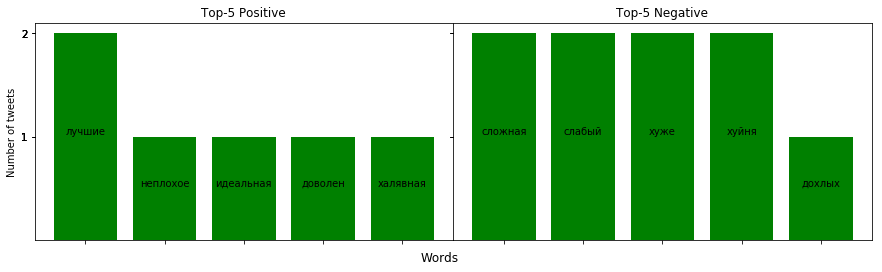

In [9]:
def autolabel(container, origin, words):
    for bar, word in zip(container, words):
        height = bar.get_height()
        width = bar.get_width()
        origin.text(bar.get_x() + width/2, height/2, word, ha='center', va='bottom')
    

f, (pos_bar, neg_bar) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 4))
f.subplots_adjust(wspace=0)
f.text(0.5, 0.05, 'Words', ha='center', fontsize=12)
plt.yticks(words_number)
pos_bar.set_ylabel('Number of tweets')

array = np.arange(5)

pos_bar_container = pos_bar.bar(array, words_number[:5], color='g')
pos_bar.set_title('Top-5 Positive')
neg_bar_container = neg_bar.bar(array, words_number[5:], color='g')
neg_bar.set_title('Top-5 Negative')

for a in f.axes[:]:
    a.tick_params(axis='x', which='both', top='off', labelbottom='off')

autolabel(pos_bar_container, pos_bar, words[:5])
autolabel(neg_bar_container, neg_bar, words[5:])
plt.savefig('adjectives.png')
plt.show()

In [10]:
# 6. распределение по времени
def plus_ten(time):
    hour = int(time[0])
    minute = int(time[1])
    if minute>=50:
        hour += 1
        hour %= 24
        minute += 10
        minute %= 60
    else:
        minute += 10
    
    minute = str(minute)
    if len(minute) < 2:
        minute = '0' + minute
    hour = str(hour)
    if len(hour) < 2:
        hour = '0' + hour
    
    return [hour, minute]


hours = open('hours.txt', 'w', encoding = 'utf8')

# estimated reviews sorted by date
date_sort_rev = sorted(estimated_reviews, key=lambda tweet: (int(tweet[0][0]), int(tweet[0][1]))) 
number_of_tweets = 0
number_of_pos = 0
number_of_neg = 0
number_of_neut = 0
time_plot = []
number_plot = []
pos_plot = []
neu_plot = []
neg_plot = []
last = plus_ten(date_sort_rev[0][0])

for tw in date_sort_rev:
    number_of_tweets += 1
    if (tw[0][0] >= last[0])&(tw[0][1] >= last[1]):
        time_plot.append(str(last[0])+':'+str(last[1]))
        number_plot.append(number_of_tweets)
        pos_plot.append(round(number_of_pos/number_of_tweets, 2))
        neu_plot.append(round(number_of_neut/number_of_tweets, 2))
        neg_plot.append(round(number_of_neg/number_of_tweets, 2))
        hours.write(date_sort_rev[0][0][0]+':'+date_sort_rev[0][0][1]+' - '+time_plot[-1]+' : '+str(number_plot[-1])+' '+\
                    str(pos_plot[-1])+'/'+str(neu_plot[-1])+'/'+str(neg_plot[-1])+'\n')
        last = plus_ten(last)  
    if (tw[2] == 0):
        number_of_neut += 1
    elif(tw[2] == 1):
        number_of_pos += 1
    else:
        number_of_neg += 1

        
time_plot.append(str(last[0])+':'+str(last[1]))
number_plot.append(number_of_tweets)
pos_plot.append(round(number_of_pos/number_of_tweets, 2))
neu_plot.append(round(number_of_neut/number_of_tweets, 2))
neg_plot.append(round(number_of_neg/number_of_tweets, 2))
hours.write(date_sort_rev[0][0][0]+':'+date_sort_rev[0][0][1]+' - '+time_plot[-1]+' : '+str(number_plot[-1])+' '+\
                    str(pos_plot[-1])+'/'+str(neu_plot[-1])+'/'+str(neg_plot[-1])+'\n')
hours.close()

for i in range(5):
    print(date_sort_rev[0][0][0]+':'+date_sort_rev[0][0][1]+' - '+time_plot[i]+' : '+str(number_plot[i])+' '+\
          str(pos_plot[i])+'/'+str(neu_plot[i])+'/'+str(neg_plot[i]))

16:22 - 16:32 : 35 0.31/0.46/0.2
16:22 - 16:42 : 50 0.3/0.38/0.3
16:22 - 16:52 : 63 0.32/0.38/0.29
16:22 - 17:02 : 74 0.3/0.43/0.26
16:22 - 17:12 : 78 0.29/0.44/0.26


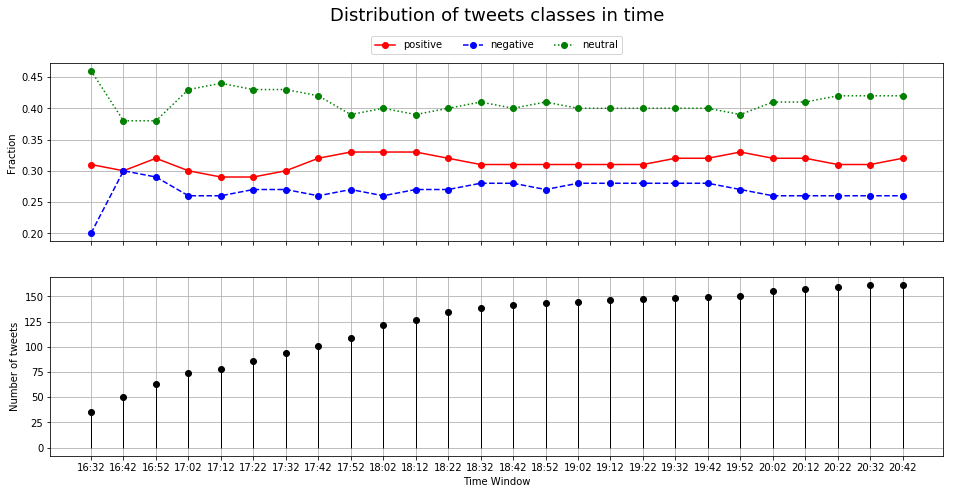

In [11]:
fig = plt.figure(figsize=(16, 7))
fig.subplots_adjust(bottom=0.1)

fraction_graph = fig.add_subplot(211)
fraction_graph.set_ylabel('Fraction')
fraction_graph.set_title('Distribution of tweets classes in time', y=1.2, size=18)
fraction_graph.grid()

x=[i for i in range(len(time_plot))]
plt.xticks(x, time_plot)

pos_line = fraction_graph.plot(pos_plot,'ro-',label='positive')
neg_line = fraction_graph.plot(neg_plot,'bo--',label='negative')
neu_line = fraction_graph.plot(neu_plot,'go:',label='neutral')

lines = pos_line+neg_line+neu_line
labels = [l.get_label() for l in lines]
fraction_graph.legend(lines, labels, bbox_to_anchor=(0, 1.02, 1, 100), loc=8, ncol=3)

for a in fig.axes[:]:
    a.tick_params(axis='x', which='both', top='off', labelbottom='off')

numb_of_tweets = fig.add_subplot(212)
numb_of_tweets.plot(number_plot,'ko')
numb_of_tweets.set_xlabel('Time Window')
numb_of_tweets.set_ylabel('Number of tweets')
numb_of_tweets.grid()

for i in range(len(time_plot)):
    numb_of_tweets.vlines(x=i, ymin=0, ymax=number_plot[i], lw=1, color='k')

plt.xticks(x, time_plot)
plt.savefig('hours.png')
plt.show()

In [12]:
# 7*. ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ. Определение точности эмпирической оценки твитов.
# words_check_estimation = [['word', -1label, -1.5mean, 0.5difference], ...]
words_check_estimation = copy.deepcopy(words_with_estimation)
wrong = 0
for word in words_check_estimation:
    number_of_tweets = 0
    mean = 0
    for tw in estimated_reviews:
        if word in tw[1]:
            number_of_tweets += 1
            mean += int(tw[2])

    words_check_estimation[word].append(mean/number_of_tweets)
    difference = abs(words_check_estimation[word][1]-mean/number_of_tweets)
    words_check_estimation[word].append(difference)
    if difference > 0.5:
        wrong += 1

        
sorted_words_check_estimation = sorted(words_check_estimation.items(), key=lambda k: k[1][3])
est_check = open('estimation_check.txt', 'w', encoding = 'utf8')

est_check.write('Top-5 Closest:\n')
print('Top-5 Closest:')
for i in range(5):
    print(sorted_words_check_estimation[i][0]+' '+str(sorted_words_check_estimation[i][1][1])+' '+str(sorted_words_check_estimation[i][1][2]))
    est_check.write(sorted_words_check_estimation[i][0]+' '+str(sorted_words_check_estimation[i][1][1])+' '+str(sorted_words_check_estimation[i][1][2])+'\n')

est_check.write('\nTop-5 Furthest:\n')
print('\nTop-5 Furthest:')
for i in range(5):
    i = len(sorted_words_check_estimation) - i - 1
    print(sorted_words_check_estimation[i][0] + ' ' + str(sorted_words_check_estimation[i][1][1]) + ' ' + str(sorted_words_check_estimation[i][1][2]))
    est_check.write(sorted_words_check_estimation[i][0] + ' ' + str(sorted_words_check_estimation[i][1][1]) + ' ' + str(sorted_words_check_estimation[i][1][2])+'\n')

print('\nEstimation accuracy: '+str(round((1 - wrong/len(words_check_estimation)) * 100))+'%')
est_check.write('\nEstimation accuracy: '+str(round((1 - wrong/len(words_check_estimation)) * 100))+'%\n')

est_check.close()

Top-5 Closest:
верно 1 1.0
франция 0 0.0
австралия 0 0.0
перу 0 0.0
дания 0 0.0

Top-5 Furthest:
сильный 1 -1.0
ждал 1 -1.0
фаворит 1 -1.0
тяжелым -1 1.0
сложно -1 1.0

Estimation accuracy: 60%


In [13]:
# 8*. ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ. Определить слова с самой положительной и отрицательной окраской.
# words = [['word', -1label, -1.5mean, 0.5difference]]
words = []
words_number = []

best = open('best_worst.txt', 'w', encoding = 'utf8')
sorted_words_best = sorted(words_check_estimation.items(), key=lambda k: (k[1][2], k[1][0]), reverse=True)#(abs(k[1][2]), k[1][0]), reverse = True) #сортировать еще и по количествуу

print('Top-5 Most Positive:')
best.write('Top-5 Most Positive:\n')
for i in range(5):
    print(sorted_words_best[i][0] + ' ' + str(sorted_words_best[i][1][2]))
    best.write(sorted_words_best[i][0] + ' ' + str(sorted_words_best[i][1][2]) + '\n')
    words.append(sorted_words_best[i][0])
    words_number.append(sorted_words_best[i][1][0])

sorted_words_best = sorted(words_check_estimation.items(), key=lambda k: ((-k[1][2]), k[1][0]), reverse=True)#(abs(k[1][2]), k[1][0]), reverse = True) #сортировать еще и по количествуу

print('\nTop-5 Most Negative:')
best.write('Top-5 Most Negative:\n')
for i in range(5):
    print(sorted_words_best[i][0] + ' ' + str(sorted_words_best[i][1][2]))
    best.write(sorted_words_best[i][0] + ' ' + str(sorted_words_best[i][1][2]) + '\n')
    words.append(sorted_words_best[i][0])
    words_number.append(sorted_words_best[i][1][0])

best.close()

Top-5 Most Positive:
сложно 1.0
выходить 1.0
шансы 1.0
выход 1.0
арабы 1.0

Top-5 Most Negative:
смерти -1.0
соперников -1.0
египта -1.0
сила -1.0
слабый -1.0


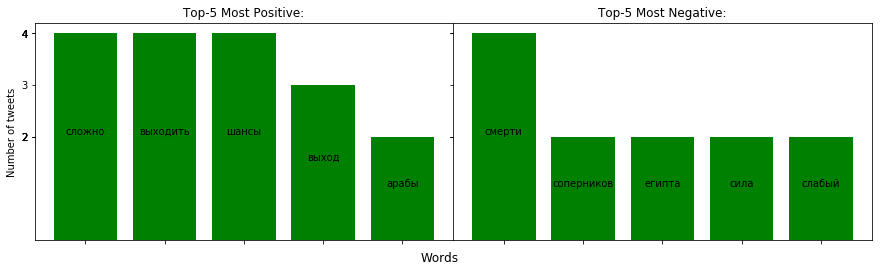

In [14]:
def autolabel(container, origin, words):
    for bar, word in zip(container, words):
        height = bar.get_height()
        width = bar.get_width()
        origin.text(bar.get_x() + width/2, height/2, word, ha='center', va='bottom')
    

f, (pos_bar, neg_bar) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 4))
f.subplots_adjust(wspace=0)
f.text(0.5, 0.05, 'Words', ha='center', fontsize=12)
plt.yticks(words_number)
pos_bar.set_ylabel('Number of tweets')

array = np.arange(5)

pos_bar_container = pos_bar.bar(array, words_number[:5], color='g')
pos_bar.set_title('Top-5 Most Positive:')
neg_bar_container = neg_bar.bar(array, words_number[5:], color='g')
neg_bar.set_title('Top-5 Most Negative:')

for a in f.axes[:]:
    a.tick_params(axis='x', which='both', top='off', labelbottom='off')

autolabel(pos_bar_container, pos_bar, words[:5])
autolabel(neg_bar_container, neg_bar, words[5:])
plt.savefig('best_worst.png')
plt.show()